In [33]:
# Initialize task.
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as snb
import matplotlib.colors as colors
from scipy.stats import norm
from scipy.optimize import minimize
from jax import hessian, random

snb.set_theme(font_scale=1.25)

# Load Data

data = jnp.load('./data_exercise5b.npz')
X = data['day']
y = np.log(data['bike_count'])

#Standardize data
ym, ys = jnp.mean(y), jnp.std(y)
y = (y - ym) / ys

## Part 1: Fully Bayesian inference for Gaussian process regression 

**Task 1.1 Choose a value for $\textit{v}$ such that the prior probability of observing a lengthscale larger than 100 is approximately $1\%$**

First, we identify that our lengthscale parameter follows af half normal distribution 

\begin{equation*}
    \ell \sim \mathcal{N}_+(0,v)
\end{equation*}

We know the condition we need to fulfill is

\begin{equation*}
    P(\ell > 100) \approx 0.01
\end{equation*}

We can express our distribution $\ell = |Z\sqrt{v}|$ with $Z$ being a standard normal variable, since $\ell$ is a half normal. Since the standard normal distribution is symmetric we view it as a two-tailed probability.

\begin{align*}
P(\ell > 100) = P(|Z\sqrt{v}| > 100) &\approx 0.01 \\
P(|Z| > \frac{100}{\sqrt{v}}) &\approx 0.01 \hspace{2cm} (\text{Two-tailed}) \\
2 \cdot P(\frac{Z > 100}{ \sqrt{v}}) &\approx 0.01 \\
P(\frac{Z > 100}{ \sqrt{v}}) &\approx 0.005\\
\Rightarrow v = \left(\frac{100}{z_{0.005}} \right)^2 = 1507.18 &\approx 1507 
\end{align*}


So when $v \approx 1507$ the probability of the lengthscale parameter being above 100 will be roughly 1%

**Task 1.2 Determine the marginalized distribution $p(y,\sigma, k, \ell)$**

The joint distribution is as follows
$$
\begin{align*} p(\boldsymbol{y}, f, \sigma, \kappa, \ell) & =p\left(y \mid \boldsymbol{f}, \sigma^2\right) p(f \mid \kappa, \ell) p(\kappa) p(\ell) p(\sigma) \\ & =\mathcal{N}\left(\boldsymbol{y} \mid \boldsymbol{f}, \sigma^2 \boldsymbol{I}\right) \mathcal{N}(\boldsymbol{f} \mid \mathbf{0}, \boldsymbol{K}) \mathcal{N}_{+}(\kappa \mid 0,1) \mathcal{N}_{+}(\ell \mid 0, v) \mathcal{N}_{+}(\sigma \mid 0,1).
\end{align*}
$$


Denoting $\mathcal{N}_{+}(\kappa \mid 0,1) \mathcal{N}_{+}(\ell \mid 0, v) \mathcal{N}_{+}(\sigma \mid 0,1) = p(\kappa,\ell,\sigma)$ we get the following for marginalising out $f$ from the joint distribution:
$$
\begin{align*}
p(\boldsymbol{y}, \sigma, \kappa, \ell) 
&= 
\int p(\boldsymbol{y}, f, \sigma, \kappa, \ell)\ \text{d}f \\
&= 
p(\kappa,\ell,\sigma)
\underbrace{\int \mathcal{N}\left(\boldsymbol{y} \mid \boldsymbol{f}, \sigma^2 \boldsymbol{I}\right) \mathcal{N}(\boldsymbol{f} \mid \mathbf{0}, \boldsymbol{K})\ \text{d}f}_{\text{Marginal likelihood = linear Gaussian system}} \\
&=
p(\kappa,\ell,\sigma) \mathcal{N}(\boldsymbol{y} \mid \mathbf{0}, \boldsymbol{K} + \sigma^2 \boldsymbol{I})
\end{align*}
$$


**Task 1.3: Implement a Metropolis sampler using the proposal distribution**

In [ ]:
def metropolis(log_target, num_params, tau, num_iter, theta_init=None, seed=0):
    """Runs a Metropolis-Hastings sampler

    Arguments:
    log_target:         function for evaluating the log target distribution, i.e. log \tilde{p}(theta). The function expect a parameter of size num_params.
    num_params:         number of parameters of the joint distribution (integer)
    tau:                standard deviation of the Gaussian proposal distribution (positive real)
    num_iter:           number of iterations (integer)
    theta_init:         vector of initial parameters (jnp.array with shape (num_params) or None)
    seed:               seed (integer)

    returns
    thetas              jnp.array with MCMC samples (jnp.array with shape (num_iter+1, num_params))
    """

    # set initial key
    key = random.PRNGKey(seed)

    if theta_init is None:
        theta_init = jnp.zeros((num_params))

    # prepare lists
    thetas = [theta_init]
    accepts = []
    log_p_theta = log_target(theta_init)

    for k in range(num_iter):

        # update keys: key_proposal for sampling proposal distribution and key_accept for deciding whether to accept or reject.
        key, key_proposal, key_accept = random.split(key, num=3)

        # get the last value for theta and generate new proposal candidate
        theta_cur = thetas[-1]
        theta_star = theta_cur + tau * random.normal(key_proposal, shape=(num_params,))

        # evaluate the log density for the candidate sample
        log_p_theta_star = log_target(theta_star)

        # compute acceptance probability
        log_r = log_p_theta_star - log_p_theta
        A = min(1, jnp.exp(log_r))

        # accept new candidate with probability A
        if random.uniform(key_accept) < A:
            theta_next = theta_star
            log_p_theta = log_p_theta_star
            accepts.append(1)
        else:
            theta_next = theta_cur
            accepts.append(0)

        thetas.append(theta_next)

    print("Acceptance ratio: %3.2f" % jnp.mean(jnp.array(accepts)))

    # return as jnp.array
    thetas = jnp.stack(thetas)

    # check dimensions and return
    assert thetas.shape == (
        num_iter + 1,
        num_params,
    ), f"The shape of thetas was expected to be ({num_iter+1}, {num_params}), but the actual shape was {thetas.shape}. Please check your code."
    return thetas, accepts

In [37]:
def metropolis_multiple_chains(
    log_target, num_params, num_chains, tau, num_iter, theta_init, seeds, warm_up=0
):
    """Runs multiple Metropolis-Hastings chains. The i'th chain should be initialized using the i'th vector in theta_init, i.e. theta_init[i, :]

    Arguments:
        log_target:         function for evaluating the log joint distribution
        num_params:         number of parameters of the joint distribution (integer)
        num_chains:         number of MCMC chains
        tau:                variance of Gaussian proposal distribution (positive real)
        num_iter:           number of iterations for each chain (integer)
        theta_init:         array of initial values (jnp.array with shape (num_chains, num_params))
        seeds:              seed for each chain (jnp.array with shape (num_chains))
        warm_up:            number of warm up samples to be discarded

    returns:
        thetas              jnp.array of samples from each chain after warmup (shape: num_chains x (num_iter + 1 - warm_up))
        accept_rates        jnp.array of acceptances rate for each chain (shapes: num_chains)

    """

    # verify dimension of initial parameters
    assert theta_init.shape == (
        num_chains,
        num_params,
    ), "theta_init seems to have the wrong dimensions. Plaese check your code."

    ##############################################
    # Your solution goes here
    ##############################################

    # prepare arrays for storing samples
    thetas = []
    accept_rates = []

    # run sampler for each chain
    for idx_chain in range(num_chains):
        print(f"Running chain {idx_chain}. ", end="")
        thetas_temp, accepts_temp = metropolis(
            log_target,
            num_params,
            tau,
            num_iter,
            theta_init=theta_init[idx_chain],
            seed=seeds[idx_chain],
        )
        thetas.append(thetas_temp)
        accept_rates.append(jnp.array(accepts_temp))

    thetas = jnp.stack(thetas, axis=0)
    accept_rates = jnp.stack(accept_rates, axis=0)

    # discard warm-up samples
    thetas = thetas[:, warm_up:, :]

    ##############################################
    # End of solution
    ##############################################

    # verify dimensions and return
    assert thetas.shape == (
        num_chains,
        num_iter + 1 - warm_up,
        num_params,
    ), f"The expected shape of chains is ({num_chains}, {num_iter+1-warm_up}, {num_params}) corresponding to (num_chains, num_iter+1-warm_up), but the actual shape is {thetas.shape}. Check your implementation."
    assert len(accept_rates) == num_chains
    return thetas, accept_rates

In [47]:
# Log half-normal prior.
def log_halfnormal(x, scale=1.0):
    return jnp.log(2 / scale) + norm.logpdf(x, 0, scale)


# Squared exponential kernel.
def squared_exponential_kernel(X, kappa, ell):
    """Computes the squared exponential kernel matrix.

    Arguments:
        X:                 jnp.array of shape (n, d) with n samples and d features
        kappa:             amplitude parameter (positive real)
        ell:               length scale parameter (positive real)

    Returns:
        K:                 jnp.array of shape (n, n) with the kernel matrix
    """
    sqdist = jnp.sum(X**2, 1).reshape(-1, 1) + jnp.sum(X**2, 1) - 2 * jnp.dot(X, X.T)
    return kappa**2 * jnp.exp(-0.5 / ell**2 * sqdist)

# Log joint function: returns -inf if any parameter ≤ 0.
def log_marginal_likelihood(theta, X, y, v=1507):
    kappa, ell, sigma = theta
    n = y.shape[0]
    if (kappa <= 0) or (ell <= 0) or (sigma <= 0):
        return -jnp.inf
    # Priors.
    lp_kappa = log_halfnormal(kappa, scale=1.0)
    lp_ell = log_halfnormal(ell, scale=jnp.sqrt(v))
    lp_sigma = log_halfnormal(sigma, scale=1.0)
    log_prior = lp_kappa + lp_ell + lp_sigma

    # Kernel matrix computation.
    K = squared_exponential_kernel(X, kappa, ell)
    C = K + sigma**2 * jnp.eye(n)

    # Compute the Cholesky decomposition.
    L = jnp.linalg.cholesky(C)
    v_vec = jnp.linalg.solve(L, y)

    # Compute log marginal likelihood.
    logdet_term = jnp.sum(jnp.log(jnp.diag(L)))
    quad_term   = 0.5 * jnp.sum(v_vec**2)
    const_term  = -0.5 * n * jnp.log(2 * jnp.pi)
    log_likelihood = const_term - logdet_term - quad_term

    return log_prior + log_likelihood

proposal_cov = 0.5 * jnp.array([[1, 0, 0], [0, 100, 0], [0, 0, 0.01]])

def log_target(theta):
    """Log target function for the Metropolis-Hastings sampler.

    Arguments:
        theta:             jnp.array of parameters (jnp.array with shape (num_params))

    Returns:
        log_target:        log target distribution (real number)
    """
    # Compute the log target distribution.
    log_target = log_marginal_likelihood(theta, X, y) - 0.5 * jnp.dot(
        theta, jnp.linalg.solve(proposal_cov, theta)
    )
    return log_target

In [51]:
# mcmc settings
num_chains = 4
num_iter = 10000
tau = 100
num_params = 3

warm_up = int(num_iter / 3)
seeds = jnp.arange(num_chains)

# generate initial values from N(0, 5)
key = random.PRNGKey(1)
theta_init = 5 * random.uniform(key, shape=(num_chains, num_params))

# sample
chains, accepts = metropolis_multiple_chains(
    log_target,
    num_params,
    num_chains,
    tau,
    num_iter,
    theta_init=theta_init,
    seeds=seeds,
    warm_up=warm_up,
)
# report estimated mean and variance
print(f"\nEstimated mean:\t\t{jnp.mean(chains.ravel()):+3.2f}")
print(f"Estimated variance:\t{jnp.var(chains.ravel()):+3.2f}")

Running chain 0. Acceptance ratio: 0.00
Running chain 1. Acceptance ratio: 0.68
Running chain 2. Acceptance ratio: 0.38
Running chain 3. Acceptance ratio: 0.00

Estimated mean:		-238.27
Estimated variance:	+5950252.50


**Task 1.4: Plot the trace for each parameter and report the convergence diagnostics**

Number of warm-up samples discarded: 0

Parameter 1:
  Estimated mean:         -904.29
  Estimated variance:     +4479128.50
  Effective sample size:  14
  Relative efficiency:    0.000
  ˆR:                     1.24
  MC error:               574.31

Parameter 2:
  Estimated mean:         +1322.88
  Estimated variance:     +4382053.50
  Effective sample size:  14
  Relative efficiency:    0.000
  ˆR:                     1.26
  MC error:               550.53

Parameter 3:
  Estimated mean:         -1133.39
  Estimated variance:     +5307573.00
  Effective sample size:  11
  Relative efficiency:    0.000
  ˆR:                     1.34
  MC error:               680.19


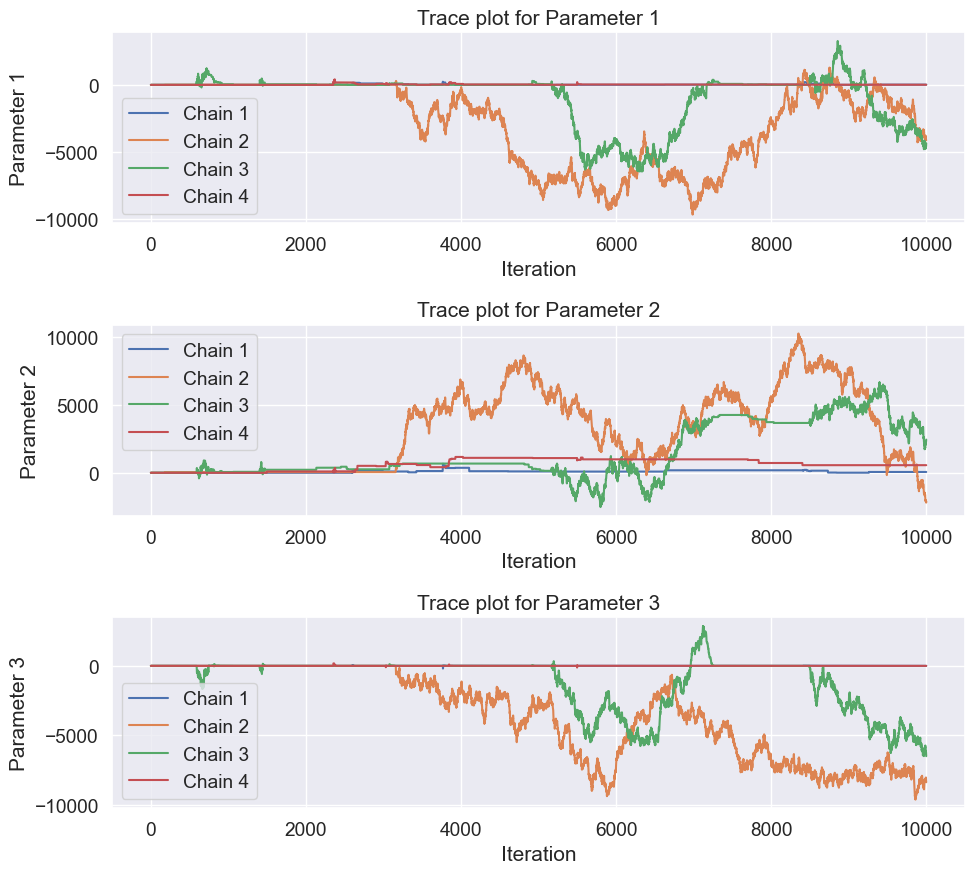

In [52]:

def compute_Rhat(chains):
    """
    Compute the Gelman-Rubin Rhat diagnostic for each parameter.
    Expects chains to be a jnp.array of shape (num_chains, num_samples, num_params).
    Returns a jnp.array of shape (num_params,).
    """
    num_chains, num_samples, num_params = chains.shape
    chain_means = jnp.mean(chains, axis=1)  # shape: (num_chains, num_params)
    overall_mean = jnp.mean(chains, axis=(0, 1))  # shape: (num_params,)
    B = (
        num_samples
        / (num_chains - 1)
        * jnp.sum((chain_means - overall_mean) ** 2, axis=0)
    )  # between-chain variance.
    # Use ddof=1 for unbiased sample variance
    W = jnp.mean(jnp.var(chains, axis=1, ddof=1), axis=0)  # within-chain variance.
    var_plus = ((num_samples - 1) / num_samples) * W + (1 / num_samples) * B
    Rhat = jnp.sqrt(var_plus / W)
    return Rhat


def compute_effective_sample_size(chains):
    """
    Compute a basic effective sample size (S_eff) approximation for each parameter.
    This implementation uses the lag autocorrelations of the merged chains.
    Returns a jnp.array of shape (num_params,).
    """
    num_chains, num_samples, num_params = chains.shape
    total_samples = int(num_chains * num_samples)
    S_eff = jnp.zeros(num_params)
    chains_np = np.array(chains)  # switch to numpy for autocorrelation computations

    for p in range(num_params):
        # merge chains for parameter p
        x = chains_np[:, :, p].reshape(-1)
        # compute autocorrelation for increasing lag until the correlation becomes negative
        ac_sum = 0.0
        for lag in range(1, num_samples):
            # compute autocorrelation at lag 'lag'
            corr = np.corrcoef(x[:-lag], x[lag:])[0, 1]
            if corr < 0:
                break
            ac_sum += corr
        S_eff = S_eff.at[p].set(total_samples / (1 + 2 * ac_sum))
    return S_eff


# Assume chains is a jnp.array of shape (num_chains, num_iter+1-warm_up, num_params)
# Also assume warm_up, num_chains, and num_iter are defined.

# Compute number of warm-up samples discarded (per chain)
total_warm_up = num_chains * warm_up
print(f"Number of warm-up samples discarded: {total_warm_up}")

# Compute estimated overall mean and variance, pooling all samples
all_samples = chains.reshape(-1, chains.shape[-1])  # shape: (total_samples, num_params)
estimated_mean = jnp.mean(all_samples, axis=0)
estimated_var = jnp.var(all_samples, axis=0)
estimated_std = jnp.sqrt(estimated_var)

# Compute convergence diagnostics.
Rhat = compute_Rhat(chains)
total_samples = num_chains * (chains.shape[1])  # after warm-up
S_eff = compute_effective_sample_size(chains)
R_eff = S_eff / total_samples
MC_error = estimated_std / jnp.sqrt(S_eff)

# Print results
for p in range(all_samples.shape[1]):
    print(f"\nParameter {p+1}:")
    print(f"  Estimated mean:         {estimated_mean[p]:+3.2f}")
    print(f"  Estimated variance:     {estimated_var[p]:+3.2f}")
    print(f"  Effective sample size:  {S_eff[p]:.0f}")
    print(f"  Relative efficiency:    {R_eff[p]:4.3f}")
    print(f"  ˆR:                     {Rhat[p]:3.2f}")
    print(f"  MC error:               {MC_error[p]:3.2f}")

# Plot trace for each parameter.
num_params = chains.shape[-1]
fig, axes = plt.subplots(num_params, 1, figsize=(10, 3 * num_params))
if num_params == 1:
    axes = [axes]  # ensure axes is iterable

for p in range(num_params):
    for chain in range(chains.shape[0]):
        axes[p].plot(chains[chain, :, p], label=f"Chain {chain+1}")
    axes[p].set_xlabel("Iteration")
    axes[p].set_ylabel(f"Parameter {p+1}")
    axes[p].set_title(f"Trace plot for Parameter {p+1}")
    axes[p].legend()

plt.tight_layout()
plt.show()